# Importing Libraries and Packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd
from google.colab import drive
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, MaxPooling2D, Multiply, Activation
drive.mount('/content/drive')

# Defining the constants and Directories

In [ ]:
# Constants are defined here
img_height, img_width = 224, 224
batch_size = 32
num_classes = 4

train_dir = '/content/drive/MyDrive/data/train'
test_dir = '/content/drive/MyDrive/data/test'

# Data Agumentation

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.45,
    height_shift_range=0.45,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.65, 1.35],  # New augmentation field
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# fuction to create a tensorflow dataset of the augumented dataset
def create_tf_dataset_from_directory(directory, batch_size, shuffle=True):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Creating the dataset
train_dataset = create_tf_dataset_from_directory(train_dir, batch_size)
test_dataset = create_tf_dataset_from_directory(test_dir, batch_size, shuffle=False)

# we are computing the clas weights
labels = []
for _, label_batch in train_dataset:
    labels.extend(np.argmax(label_batch.numpy(), axis=1))

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

# Model Architecture and Training

In [ ]:
input_shape = (img_height, img_width, 3)
input_tensor = Input(shape=input_shape)

# DenseNet201 
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in densenet_base.layers:
    layer.trainable = True  # Unfreeze all layers of DenseNet201
densenet_output = densenet_base.output
densenet_output = GlobalAveragePooling2D()(densenet_output)

# Attention U-Net 
def attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, kernel_size=1)(x)
    phi_g = Conv2D(inter_channels, kernel_size=1)(g)
    concat = Activation('relu')(theta_x + phi_g)
    psi = Conv2D(1, kernel_size=1)(concat)
    psi = Activation('sigmoid')(psi)
    return Multiply()([x, psi])

def attention_unet(input_tensor):
    def conv_block(x, filters):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x

    def up_conv(x, skip, filters):
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(filters, (2, 2), activation='relu', padding='same')(x)
        x = attention_block(skip, x, filters // 2)  # Attention block
        x = concatenate([x, skip], axis=-1)
        return x

    filters = [64, 128, 256, 512, 1024]

    # Encoder Part of the U-Net Architecture
    conv1 = conv_block(input_tensor, filters[0])
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = conv_block(pool1, filters[1])
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = conv_block(pool2, filters[2])
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = conv_block(pool3, filters[3])
    pool4 = MaxPooling2D((2, 2))(conv4)

    conv5 = conv_block(pool4, filters[4])
    conv5 = Dropout(0.3)(conv5)

    # Decoder Part of the U-Net Architecture
    up4 = up_conv(conv5, conv4, filters[3])
    up3 = up_conv(up4, conv3, filters[2])
    up2 = up_conv(up3, conv2, filters[1])
    up1 = up_conv(up2, conv1, filters[0])

    output = GlobalAveragePooling2D()(up1)
    return output

unet_output = attention_unet(input_tensor)

# Combining the output with dense layers (ANN), Batch Normalization and L2 regularization
combined = Concatenate()([densenet_output, unet_output])
combined = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.25)(combined)
combined = Dense(num_classes, activation='softmax')(combined)

# Final model through ensemble approach
ensemble_model = Model(inputs=input_tensor, outputs=combined)

# Compiling the model also using AdamW optimizer
ensemble_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.000015, weight_decay=1e-6),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


# Define callbacks
model_save_path = '/content/drive/MyDrive/output2/Attention_UNet_DenseNet201_12.keras'
checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Model Training Parameters
history = ensemble_model.fit(
    train_dataset,
    epochs=25,
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

# Results

Mounted at /content/drive
Found 3382 files belonging to 4 classes.
Found 880 files belonging to 4 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6264 - loss: 2.5578
Epoch 1: val_accuracy improved from -inf to 0.79318, saving model to /content/drive/MyDrive/output2/Attention_UNet_DenseNet201_12.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1599s 10s/step - accuracy: 0.6279 - loss: 2.5541 - val_accuracy: 0.7932 - val_loss: 2.0603 - learning_rate: 1.5000e-05
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9540 - loss: 1.6717
Epoch 2: val_accuracy improved from 0.79318 to 0.93636, saving model to /content/drive/MyDrive/output2/Attention_UNet_DenseNet201_12.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - accuracy: 0.9541 - loss: 1.6713 - val_accuracy: 0.9364 - val_loss: 1.6241 - learning_rate: 1.5000e-05
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9818 - loss: 1.4914
Epoch 3: val_accur

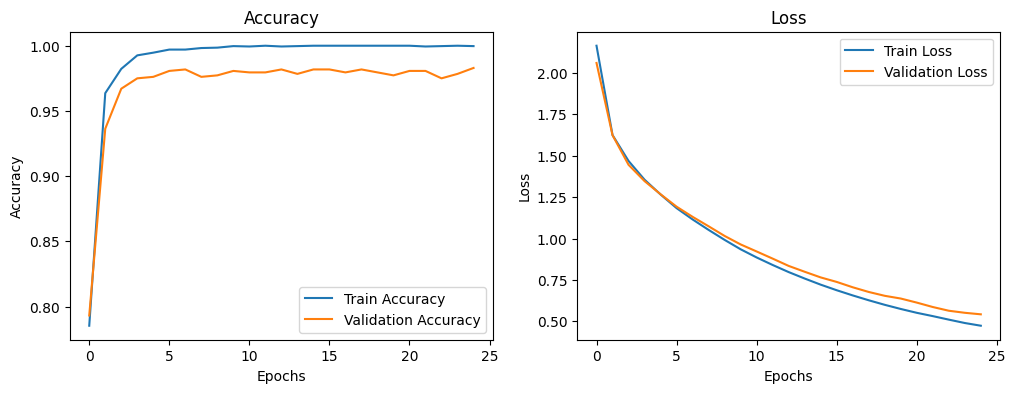

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


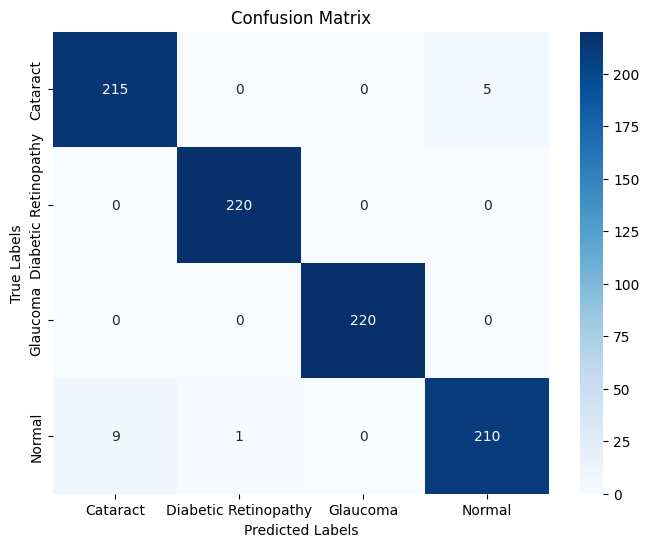

Accuracy Score: 0.9829545454545454
Classification Report:
{'Cataract': {'precision': 0.9598214285714286, 'recall': 0.9772727272727273, 'f1-score': 0.9684684684684685, 'support': 220.0}, 'Diabetic Retinopathy': {'precision': 0.995475113122172, 'recall': 1.0, 'f1-score': 0.9977324263038548, 'support': 220.0}, 'Glaucoma': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 220.0}, 'Normal': {'precision': 0.9767441860465116, 'recall': 0.9545454545454546, 'f1-score': 0.9655172413793104, 'support': 220.0}, 'accuracy': 0.9829545454545454, 'macro avg': {'precision': 0.9830101819350281, 'recall': 0.9829545454545455, 'f1-score': 0.9829295340379085, 'support': 880.0}, 'weighted avg': {'precision': 0.9830101819350281, 'recall': 0.9829545454545454, 'f1-score': 0.9829295340379084, 'support': 880.0}}


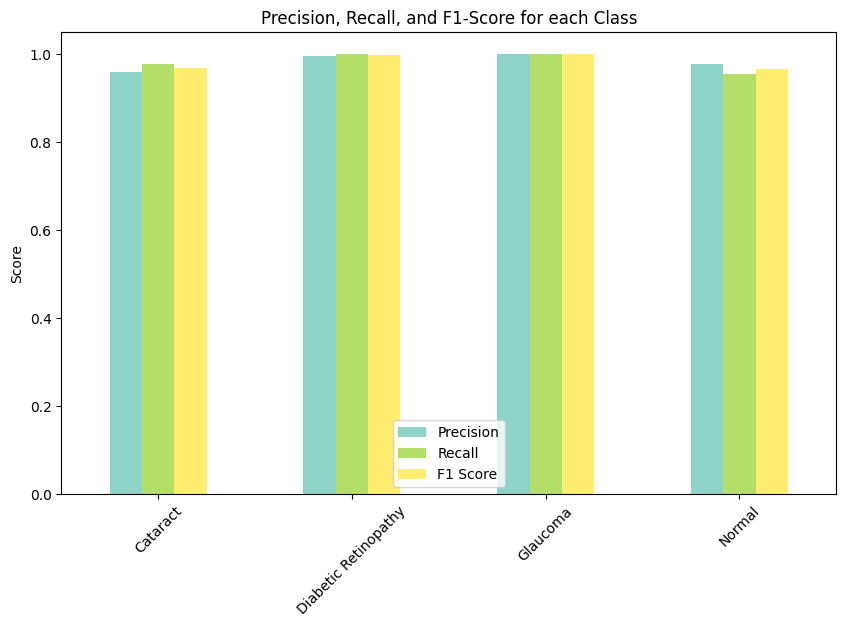

In [ ]:

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Making predictions
def predict_and_get_labels(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_pred_batch = np.argmax(preds, axis=-1)
        y_true_batch = np.argmax(labels, axis=-1)

        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)

    return np.array(y_true), np.array(y_pred)

# Generating labels for the predictions
y_true, y_pred = predict_and_get_labels(ensemble_model, test_dataset)

# Computing the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal'],
            yticklabels=['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# accuracy score
print(f'Accuracy Score: {accuracy_score(y_true, y_pred)}')

# Classification Report
report = classification_report(y_true, y_pred, target_names=['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal'], output_dict=True)
print("Classification Report:")
print(report)

# Extract precision, recall, and f1-score for plotting
precision = [report[label]['precision'] for label in ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']]
recall = [report[label]['recall'] for label in ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']]
f1_score = [report[label]['f1-score'] for label in ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']]
labels = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']

# Plot precision, recall, and f1-score
df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, index=labels)
df.plot(kind='bar', figsize=(10, 6), colormap='Set3')
plt.title('Precision, Recall, and F1-Score for each Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()